In [1]:
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import seaborn as sb
import lmdiag
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import numpy as np
from scipy.linalg import lu_factor, lu_solve
from scipy import linalg
from time import perf_counter

In [2]:
concrete = pd.read_csv('Concrete_Data.csv') #read csv file

# EDA

In [3]:
y = concrete.iloc[:, -1:]
x = concrete.iloc[:, :-1]

In [4]:
x = sm.add_constant(x)

<AxesSubplot: >

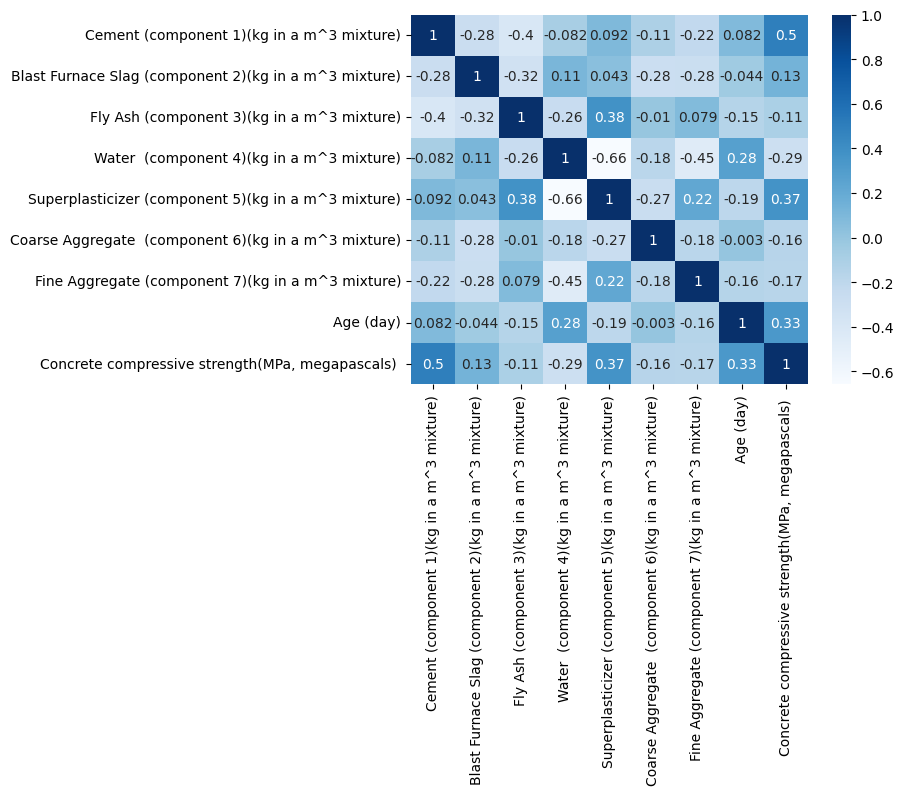

In [5]:
corr = concrete.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

In [7]:
model = sm.OLS(y,x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)

                                           OLS Regression Results                                           
Dep. Variable:     Concrete compressive strength(MPa, megapascals)    R-squared:                       0.616
Model:                                                          OLS   Adj. R-squared:                  0.613
Method:                                               Least Squares   F-statistic:                     204.3
Date:                                              Wed, 08 Mar 2023   Prob (F-statistic):          6.29e-206
Time:                                                      17:24:05   Log-Likelihood:                -3869.0
No. Observations:                                              1030   AIC:                             7756.
Df Residuals:                                                  1021   BIC:                             7800.
Df Model:                                                         8                                         
Covariance Type:   

<module 'matplotlib.pyplot' from 'C:\\Users\\Treasurer Tsang\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

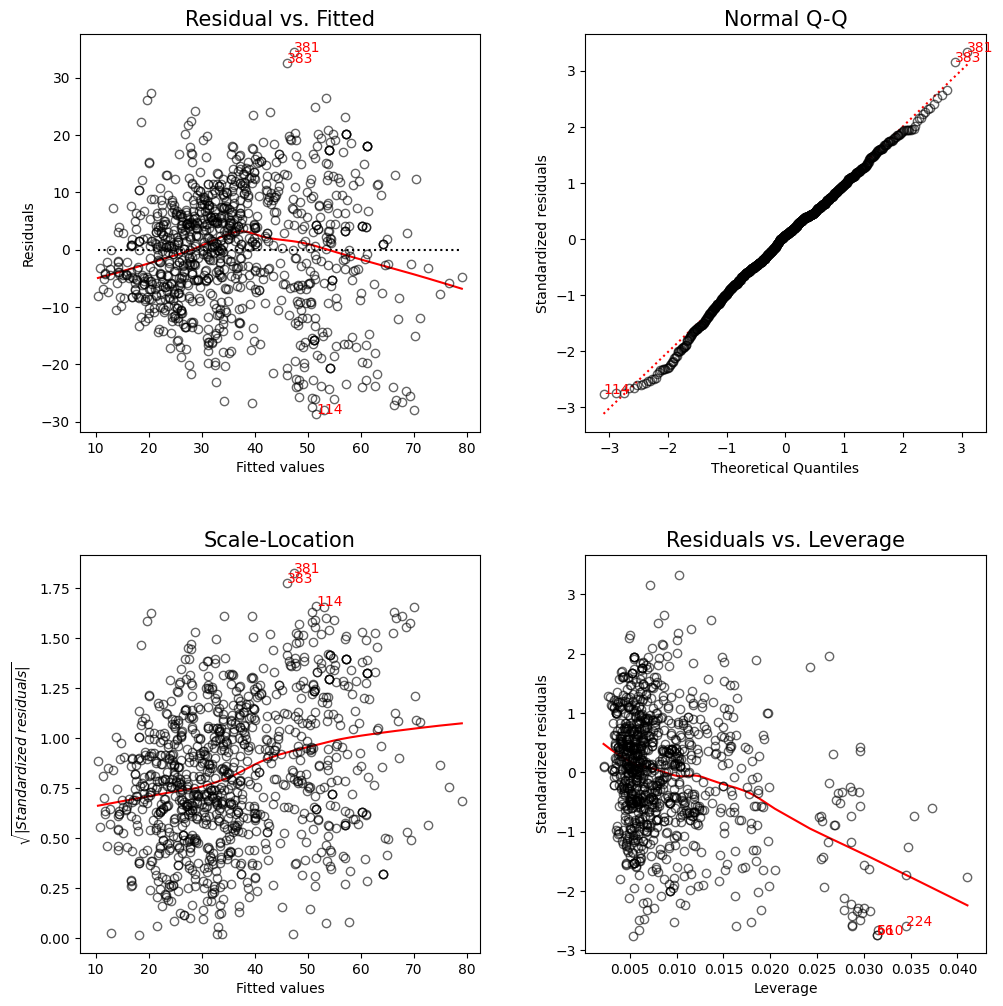

In [8]:
plt.figure(figsize = (10,10))
lmdiag.plot(model)

# Data Preprocessing

In [9]:
df_n, df_m = concrete.shape

In [10]:
X = concrete.iloc[:, :-1].to_numpy()
Y = concrete.iloc[:, -1].to_numpy().reshape(df_n, 1)

In [11]:
X_n, X_m = X.shape

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=156)

In [13]:
X_scaler = preprocessing.StandardScaler().fit(X_train)
Y_scaler = preprocessing.StandardScaler().fit(Y_train)

X_scaled = X_scaler.transform(X_train)
Y_scaled = Y_scaler.transform(Y_train)

In [14]:
print(sm.OLS(Y_scaled,X_scaled).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.628
Model:                            OLS   Adj. R-squared (uncentered):              0.625
Method:                 Least Squares   F-statistic:                              161.5
Date:                Wed, 08 Mar 2023   Prob (F-statistic):                   1.36e-158
Time:                        17:24:33   Log-Likelihood:                         -713.29
No. Observations:                 772   AIC:                                      1443.
Df Residuals:                     764   BIC:                                      1480.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# LU Decomposition

In [22]:
A = X_scaled.T @ X_scaled
b = X_scaled.T @ Y_scaled

In [16]:
A_n = A.shape[0]

In [17]:
def retrieve_coef(beta, x, y):
    ''' 
    Function to retrieve the unscaled betas and intercept.
    Beta is an (n x 1) vector containing the beta estimates from scaled data.
    X is the scaled X array (with no intercept column).
    Y is the scaled Y array.

    The output is an (n+1 x 1) containin the intercept and beta estimates.
    '''
    # add intercept
    beta = np.vstack((0, beta))
    
    # calculate coefficients
    ret_coef = np.std(y) / np.std(x, axis=0) * beta.ravel()[1:] 
    n = len(ret_coef)
    ret_coef = ret_coef.reshape((n, 1))

    # calculate intecept
    y_bar = np.mean(y)
    x_bars = np.mean(x, axis=0)

    betax = []

    for a, b in zip(beta, x_bars):
        betax.append(a*b)

    sum_betax = np.sum(betax)
    
    beta0 = y_bar - sum_betax

    # combine intercept and coefficients
    coef = np.vstack((beta0, ret_coef))

    return coef

In [20]:
# before scaling without intercept
lu, piv = lu_factor(x.T@x)
b_noscale = linalg.lu_solve((lu, piv), x.T@y)

In [21]:
b_noscale

array([[-2.33312136e+01],
       [ 1.19804334e-01],
       [ 1.03865809e-01],
       [ 8.79343215e-02],
       [-1.49918419e-01],
       [ 2.92224595e-01],
       [ 1.80862148e-02],
       [ 2.01903511e-02],
       [ 1.14222068e-01]])

In [26]:
#after scaling without intercept
start = perf_counter()

lu, piv = lu_factor(A)
lu_scale = linalg.lu_solve((lu, piv), b)

stop = perf_counter()

In [27]:
lu_scale

array([[ 0.78880719],
       [ 0.5654493 ],
       [ 0.3618959 ],
       [-0.15467212],
       [ 0.11996473],
       [ 0.09794694],
       [ 0.12021513],
       [ 0.44065328]])

In [25]:
stop - start

0.0007245999295264482

In [28]:
retrieve_coef(lu_scale, X_train, Y_train)

array([[-3.17393714e+02],
       [ 1.26157802e-01],
       [ 1.10049310e-01],
       [ 9.56786137e-02],
       [-1.21655854e-01],
       [ 3.43872340e-01],
       [ 2.11936709e-02],
       [ 2.50738277e-02],
       [ 1.11873182e-01]])

In [33]:
# variance
yxb = np.subtract(Y_scaled, X_scaled@lu_scale) # y - xB (B is beta hat)
lu_var = yxb.T@yxb/(len(X_scaled)-8) #(n-p)
lu_var

array([[0.37547685]])

In [32]:
# MSE
lu_var/len(X_scaled)

array([[0.00048637]])